# Llama 2 padding

We noticed that batched inference was broken with Llama 2, which seemed due to left-padding with end-of-sequence.

This seems to occur in padded examples when there are sufficient un-padded tokens (short sequences don't seem to trigger the issue). It can be fixed by padding with BOS, although this may be a hack.

We're trying to understand a little more about this.

In [1]:
# %pip install git+https://github.com/graphcore-research/pytorch-tensor-tracker
%load_ext autoreload
%autoreload 2
import torch
from torch import Tensor
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import llminference as L
import tensor_tracker

In [2]:
adapter = L.Adapter.from_pretrained("meta-llama/Llama-2-7b-hf", dtype=torch.float16)
adapter.model.cuda();

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In the following example, batch size 3, the first sequence [0] exhibits the problem, the second [1] is padded but has no issue, and the third [2] isn't padded.

In [46]:
# adapter.tokenizer.pad_token = adapter.tokenizer.eos_token
# adapter.tokenizer.pad_token = adapter.tokenizer.bos_token
with tensor_tracker.track(adapter.model) as tracker:
    print(adapter.tokenizer.batch_decode(adapter.greedy_sample(["\nYou are not very", "\nI am", "abc"*20], ["", "", ""], 1)))

['<unk>', 'a', 'abc']


/home/ubuntu/LLMInference/.venv/lib/python3.8/site-packages/torch/nn/modules/module.py:1554: UserWarning: For backward hooks to be called, module output should be a Tensor or a tuple of Tensors but received <class 'transformers.modeling_outputs.BaseModelOutputWithPast'>
  warnings.warn("For backward hooks to be called,"
/home/ubuntu/LLMInference/.venv/lib/python3.8/site-packages/torch/nn/modules/module.py:1554: UserWarning: For backward hooks to be called, module output should be a Tensor or a tuple of Tensors but received <class 'transformers.modeling_outputs.CausalLMOutputWithPast'>
  warnings.warn("For backward hooks to be called,"


## 1. Where does the error first occur?

Using `torch.isfinite` to detect inf or NaN, we see that the "hard" numerical issue first appears after `model.layers.30.mlp.down_proj`.

In [47]:
[s.name for s in tracker.stashes if isinstance(s.first_value, Tensor) and not torch.isfinite(s.first_value).all()]

['model.layers.30.mlp.down_proj',
 'model.layers.30.mlp',
 'model.layers.30',
 'model.layers.31.input_layernorm',
 'model.layers.31.self_attn.q_proj',
 'model.layers.31.self_attn.k_proj',
 'model.layers.31.self_attn.v_proj',
 'model.layers.31.self_attn.o_proj',
 'model.layers.31.self_attn',
 'model.layers.31.post_attention_layernorm',
 'model.layers.31.mlp.gate_proj',
 'model.layers.31.mlp.act_fn',
 'model.layers.31.mlp.up_proj',
 'model.layers.31.mlp.down_proj',
 'model.layers.31.mlp',
 'model.layers.31',
 'model.norm',
 'lm_head']

We investigate further, and see that the issue begins with a range error, as `mlp.down_proj` overflows to -inf in position [0].

The next `layernorm` changes the -inf error to NaN, still only in position [0].

The next `self_attn` propagates the error to all positions (since the llama attention code uses an additive log(mask) that retains NaN).

In [48]:
print("# Minimum hidden value for each position in the sequence, for the bad batch item only.")
print()
stash_dict = {s.name: s for s in tracker.stashes}
for key in ["model.layers.30.mlp.up_proj", "model.layers.30.mlp.down_proj", "model.layers.30", "model.layers.31.input_layernorm", "model.layers.31.self_attn", "model.layers.31"]:
    min_values = stash_dict[key].first_value[0].min(dim=-1).values
    print(f"    {key:<35}", [*min_values[:2].tolist(), "...", *min_values[-2:].tolist()])

# Minimum hidden value for each position in the sequence, for the bad batch item only.

    model.layers.30.mlp.up_proj         [-9.984375, -4.4765625, '...', -25.25, -24.46875]
    model.layers.30.mlp.down_proj       [-inf, -1839.0, '...', -4.9453125, -6.4296875]
    model.layers.30                     [-inf, -1641.0, '...', -13.5625, -17.6875]
    model.layers.31.input_layernorm     [nan, -10.40625, '...', -4.20703125, -3.291015625]
    model.layers.31.self_attn           [nan, nan, '...', nan, nan]
    model.layers.31                     [nan, nan, '...', nan, nan]


## Why does position [0] overflow?

We tried to investigate why position [0] overflows (for some sequences not others), and the following plots look at the distribution over position-in-sequence just before the error occurs, showing a large standard devation for the position that is just about to overflow.

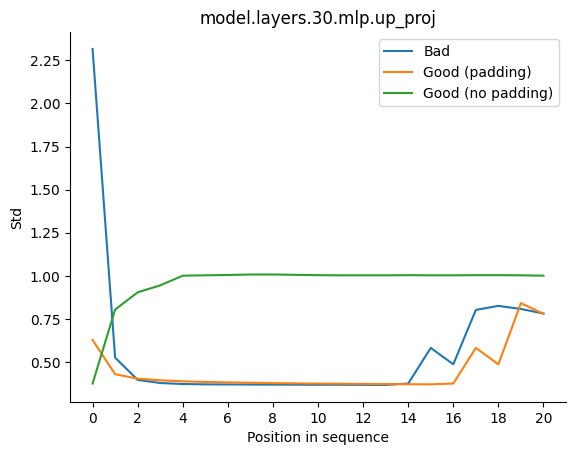

In [50]:
hidden = stash_dict["model.layers.30.mlp.up_proj"].value
plt.title("model.layers.30.mlp.up_proj")
plt.plot(hidden.std(dim=-1).T)
plt.legend(["Bad", "Good (padding)", "Good (no padding)"])
plt.ylabel("Std")
plt.xlabel("Position in sequence")
plt.xticks(torch.arange(0, 21, 2))
sns.despine();

Trying to see where this spike in standard deviation comes from is hard; we look at the standard deviation of activations at position 0 for the padded sequences, and see some interesting spikes, but nothing conclusive.

We assume that, since the error depends on how many "real" tokens are at the end of the padded sequence, it must depend on self-attention layers, but have no further thoughts on this.

Ultimately, we declare this line uninteresting, as the invariant we would like to assume is that "masked (padding) tokens should never influence non-masked (real) tokens", which means that the cause of an overflow in the padding is irrelevant. Self-attention should protect the real tokens in any case.

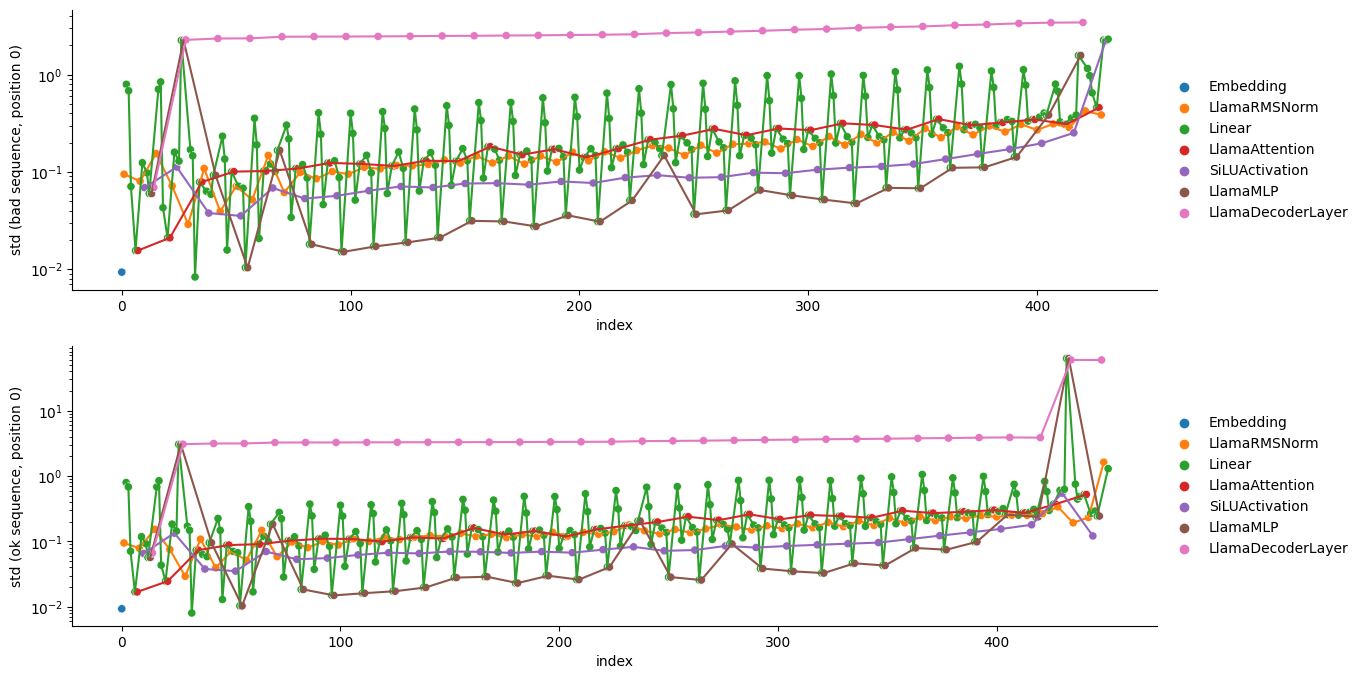

In [51]:
df = pd.DataFrame.from_dict(
    [dict(index=n, type=s.type.__name__, bad=float(s.first_value[0, 0].std()), ok=float(s.first_value[1, 0].std()))
     for n, s in enumerate(tracker) if isinstance(s.first_value, Tensor) and s.first_value.shape[0] == 3]
)
_, axs = plt.subplots(2, 1, figsize=(14, 8))
for (ax, k) in zip(axs, ["bad", "ok"]):
    sns.scatterplot(data=df, y=k, x="index", hue="type", ax=ax)
    sns.lineplot(data=df, y=k, x="index", hue="type", legend=False, ax=ax)
    ax.set_yscale("log")
    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
    ax.set_ylabel(f"std ({k} sequence, position 0)")
    sns.despine(ax=ax)